# Ejercicio 1

Para esta seccion, seleccionamos un corpus de la biblioteca nltk. Para este ejercicio seleccionamos el corpus **cess_es**. Este corpus consiste un texto de noticias en espanol

In [1]:
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math   

from preprocesador import *
from subword import *
from frecuencias import *

os.environ["NLTK_DATA"]="datos_nltk/"
import  nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer

## Paso 1
Nos aseguramos de tener disponible el corpus **cess_esp**. Aprovechamos la funcionalidad de nltk para obtener las oraciones del corpus.




In [8]:
## Seleccionamos un corpus en español que se encuentra en nltk
from nltk.corpus import cess_esp

nltk.download("cess_esp")

## Obtenemos las oraciones del corpus para el entrenamiento de nuestra red neuronal
corpus_sents = cess_esp.sents()[0:1000]

print("Numero de oraciones en el corpus:", len(corpus_sents))

[nltk_data] Downloading package cess_esp to /home/joel/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Numero de oraciones en el corpus: 1000


## Paso 2
Aplicamos un pre procesamiento a todos los tokens de nuestro corpus. Los pasos a seguir en nuestro pre procesamiento son los siguientes:
- Pasamos todos los tokens a minusculas
- Eliminamos cualquier signo de puntacion en los tokens, es decir, eliminamos cualquier signo que no sea una letra del alfabeto en español o número
- Eliminamos todos los tokens que sean identificados como _stopword_. Para la lista de _stopword_ utilizamos la lista encontrada en ntlk para el lenguaje de español
- Finalmente eliminamos acentos. En este paso, para cada token, sustituimos sus vocales acentuadas por la misma vocal sin acento.



In [ ]:
# Procedemos a normalizar el texto:
# Removiendo acentos, puntuacion y stopwords

nltk.download('stopwords')
stopwords_list = stopwords.words('spanish')

# Normalizamos los oraciones
sents_norm = [pre_procesar(oracion, stopwords_list) for oracion in corpus_sents]
# Obtenemos todas las palabras del texto
tokens_normalizados = [x for xs in sents_norm for x in xs]

print("Numero de tokens, despues del preprocesamiento:", len(tokens_normalizados))

## Paso 3

Dado nuestros tokens normalizados, procedemos a realizar a obtener sub words utilizando BPE.

In [5]:
# Entrenamos nuestro algoritmo de BPE con las palabras del corpus, obtenemos las reglas y las frecuencias de cada token
# Aplicamos 500 iteraciones
freqs_bpe, reglas_bpe = entrenar_byte_pair_encoding(tokens_normalizados, 500)

In [6]:
## Aplicamos nuestro modelo bpe a cada oraciond el corpus para obtener las oraciones tokenizadas
sents_tokenizadas = [aplicar_bpe(sent, reglas_bpe) for sent in sents_norm]

## Agregamos las etiquetas <BOS> y <EOS> a cada oracion
sents_tokenizadas = [["<BOS>"] + sent + ["<EOS>"] for sent in sents_tokenizadas]


In [7]:
# Comparacion de la primera frase en palabras y tokenizadas con BPE
print(sents_tokenizadas[0])
print(sents_norm[0])

['<BOS>', 'grupo', 'es', 'ta', 'tal', 'electrici', 'tede', 'fran', 'ce', 'edf', 'anuncio', 'hoy', 'jue', 'ves', 'com', 'pra', '5', '1porciento', 'empresa', 'mex', 'i', 'cana', 'electricidada', 'gui', 'ladealtamira', 'eaa', 'creada', 'ja', 'pones', 'mitsubis', 'hicor', 'pora', 'tion', 'poneren', 'marcha', 'central', 'gas', '495', 'megavatios', '<EOS>']
['grupo', 'estatal', 'electricitedefrance', 'edf', 'anuncio', 'hoy', 'jueves', 'compra', '51porciento', 'empresa', 'mexicana', 'electricidadaguiladealtamira', 'eaa', 'creada', 'japones', 'mitsubishicorporation', 'ponerenmarcha', 'central', 'gas', '495', 'megavatios']


In [146]:
# Tabla para ver las frecuencias de las palabras
tabla_frecuencias_bpe = crear_tabla_frecuencias(freqs_bpe)
print(tabla_frecuencias_bpe)


      palabra  frecuencia
0           a          39
1           o          25
2          ta          24
3          to          24
4          te          21
...       ...         ...
1083     cisa           1
1084  regreso           1
1085      pis           1
1086   locali           1
1087    ñadel           1

[1088 rows x 2 columns]


In [194]:
#Convertimos la tabla en un diccionario para usarlo en el modelo
palabras = tabla_frecuencias_bpe['palabra']
frecuencias = tabla_frecuencias_bpe['frecuencia']
dic_palabras = {}  
for i in range(len(frecuencias)):
    dic_palabras[palabras[i]] = frecuencias[i]
dic_palabras["<BOS>"] = len(sents_norm)
dic_palabras["<EOS>"] = len(sents_norm)

In [195]:
ETIQUETA_UNK = "<UNK>"
def indices_palabras(palabras_frecuencias: dict):
    """Calcula los indices de las palabras dadas sus frecuencias

    Parameters
    ----------
    palabras_frecuencias : dict
        Diccionario donde las llaves son las palabras y los valores sus frecuencias

    Returns
    -------
    dict,dict
        Diccionarios uno a uno de palabras a indices y viceversa
    """
    result = {}
    for ind, palabra in enumerate(palabras_frecuencias.keys()):
        # Ocurrio un Happax legomena o singleton
        if palabras_frecuencias[palabra] == 1:
            # Indice temporal para UNK
            result[ETIQUETA_UNK] = len(palabras_frecuencias)
        else:
            result[palabra] = ind

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [196]:
#Se obtienen los índices de cada palabra
palabras_a_indices, indices_a_palabras = indices_palabras(dic_palabras)
print(palabras_a_indices)
print(indices_a_palabras)
len(palabras_a_indices)

{'a': 0, 'o': 1, 'ta': 2, 'to': 3, 'te': 4, 'i': 5, 'do': 6, 'pro': 7, 'li': 8, 'en': 9, '2': 10, 'in': 11, 're': 12, 'de': 13, 'mo': 14, '1': 15, 'com': 16, 'dos': 17, 'es': 18, 'r': 19, 'da': 20, 'g': 21, 'al': 22, 'ca': 23, 'con': 24, 'si': 25, 'f': 26, 'b': 27, 'cu': 28, 'c': 29, 'e': 30, 'ma': 31, 'la': 32, 'hoy': 33, 'pp': 34, 'l': 35, 'des': 36, 'po': 37, 's': 38, 'y': 39, 'ti': 40, 'tu': 41, '3': 42, 'u': 43, 'se': 44, 'kursk': 45, 'mar': 46, 'que': 47, 'z': 48, 'di': 49, 'ci': 50, 'tro': 51, 'vo': 52, 'armada': 53, 'co': 54, 'for': 55, 'mos': 56, 'submarino': 57, 'victoria': 58, 'tas': 59, 'ne': 60, 'tar': 61, 've': 62, 'm': 63, 'dad': 64, '199': 65, 'cia': 66, 'comision': 67, 'madrid': 68, '5': 69, 'is': 70, 't': 71, 'd': 72, '0': 73, 'empresa': 74, 'mi': 75, 'ce': 76, '7': 77, 'votos': 78, 'pues': 79, 'partido': 80, 'le': 81, 'operacion': 82, 'k': 83, 'ja': 84, 'ra': 85, 'p': 86, 'tras': 87, 'er': 88, 'desarrollo': 89, 'ob': 90, 'tan': 91, '6': 92, 'dijo': 93, '8': 94, 'vi':

In [150]:
def get_id(palabra_a_id: dict, palabra: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK

    Parameters
    ----------
    palabra_a_id : dict
        Diccionario de palabras a indices
    palabra : str
        Palabra a buscar

    Returns
    -------
    int
        Indice de la palabra
    """
    id_unknow = palabra_a_id[ETIQUETA_UNK]
    return palabra_a_id.get(palabra, id_unknow)

## Paso 4
Definimos los bigramas a usar para entrenar nuestra red neuronal

In [151]:
def lista_bigramas(corpus:list, palabras_a_indices:dict) -> list:
    """Obtiene bigramas para usar en un modelo de red neuronal
    Parameters
    ----------
    corpus : list
        corpus a procesar
    indices_a_palabras : dict
        Diccionario de palabras a indices
    Returns
    -------
    list
        Conjunto de bigramas
    """
    bigramas = []
    for i in range(len(corpus)-1):
        bigrama = [get_id(palabras_a_indices, corpus[i]), get_id(palabras_a_indices, corpus[i+1])]
        bigramas.append(bigrama)
    return bigramas

In [152]:
#Obtenemos los bigramas
bigramas = lista_bigramas(tokens_normalizados, palabras_a_indices)
print(bigramas)
print(len(bigramas))

[[109, 597], [597, 597], [597, 120], [120, 127], [127, 33], [33, 597], [597, 597], [597, 597], [597, 74], [74, 597], [597, 597], [597, 305], [305, 298], [298, 597], [597, 597], [597, 597], [597, 245], [245, 255], [255, 482], [482, 228], [228, 597], [597, 120], [120, 597], [597, 494], [494, 191], [191, 562], [562, 567], [567, 566], [566, 597], [597, 597], [597, 597], [597, 255], [255, 489], [489, 597], [597, 174], [174, 245], [245, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 402], [402, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 159], [159, 597], [597, 348], [348, 375], [375, 597], [597, 305], [305, 597], [597, 597], [597, 597], [597, 345], [345, 126], [126, 120], [120, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 305], [305, 597], [597, 597], [597, 562], [562, 567], [567, 597], [597, 597], [597, 597], [597, 174], [174, 597], [597, 120], [120, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 597], [597, 5

## Paso 5

Construimos la red neuronal

In [164]:
#Inicializacion de hiperparámetros

np.random.seed(42) #Seed para la reproductibilidad
N = len(palabras_a_indices.keys()) #Longitud del vocabulario
d = 2 #Dimensión de los embeddings
m = N #Número de unidades en la capa oculta
taza_aprend = 0.01 #Rango de aprendizaje
EPOCHS = 20 #Número de iteraciones para entrenamiento

In [165]:
#Inicialización de parámetros
C = np.random.randn(d, N) / np.sqrt(N)
W =  np.random.randn(m, d) / np.sqrt(d)
b = np.random.randn(m) / np.sqrt(m)
U = np.random.randn(N,m) / np.sqrt(m)
c = np.random.randn(N) / np.sqrt(N)

In [166]:
#Función para construir el vector one-hot de una palabra a partir de su índice
def crear_one_hot(ind : int, size : int) -> list:
    onehot = np.zeros(size)
    onehot[ind] = 1
    return onehot

In [167]:
%%time
#Realizamos el entrenamiento

losses = []
for epoch in range(EPOCHS):
    # Acumula el riesgo de la epoch
    loss = 0
    for bigrama in bigramas:
        Ci = C.T[bigrama[0]]
        #Capa oculta
        WCi = np.dot(W, Ci)
        hi = np.tanh(WCi + b)

        #Pre-activacion
        ai = np.dot(U, hi) + c

        #activacion
        expai = np.exp(ai)
        f =  expai / expai.sum(0)
                
        # Calcula loss por ejemplo
        loss += -np.log(f)[bigrama[1]]

        # Backpropagation
        d_out = f
        d_out[bigrama[1]] -= 1

        U -= (taza_aprend * np.outer(d_out, hi))
        b -= taza_aprend * d_out
            
        dh = np.dot(d_out, U) * (1-(hi**2))
        W -= (taza_aprend * np.outer(dh, Ci))

        c -= taza_aprend * d_out

        dc = np.dot(dh, W)
        C.T[bigrama[0]] -= (taza_aprend * dc)

        # Guardamos el loss
    losses.append(loss)
    print(f"Epoch {epoch}, loss: {loss}")

Epoch 0, loss: 5853.147689811208
Epoch 1, loss: 5407.741127152252
Epoch 2, loss: 5468.732322449637
Epoch 3, loss: 5485.558099309901
Epoch 4, loss: 5455.239597362481
Epoch 5, loss: 5406.451390386989
Epoch 6, loss: 5355.108494280607
Epoch 7, loss: 5308.119335798615
Epoch 8, loss: 5268.709829745265
Epoch 9, loss: 5237.200841398544
Epoch 10, loss: 5212.232961265618
Epoch 11, loss: 5192.130265172847
Epoch 12, loss: 5175.701559915605
Epoch 13, loss: 5162.009071909739
Epoch 14, loss: 5150.309059007667
Epoch 15, loss: 5140.050861231707
Epoch 16, loss: 5130.845455947532
Epoch 17, loss: 5122.42125053643
Epoch 18, loss: 5114.587968556795
Epoch 19, loss: 5107.2110281335035
CPU times: user 3min 22s, sys: 8min 2s, total: 11min 24s
Wall time: 1min 37s


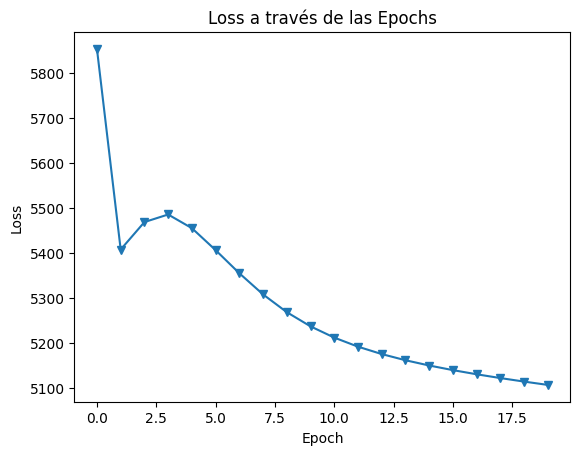

In [175]:
#Graficamos los diferentes losses a través de las iteraciones
plt.plot(losses, 'v-')
plt.title('Loss a través de las Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [177]:
def forward(ind_palabra : int, N : int):
    #Embedding
    Ci = C.T[ind_palabra]
    
    #Capa oculta
    WCi = np.dot(W, Ci)
    tanh = np.vectorize(lambda x: math.tanh(x))
    hi = tanh(WCi + b)
    #Pre-activacion
    ai = np.dot(U, hi) + c

    #activacion
    expai = np.exp(ai)
    salidas =  expai / expai.sum(0)
    return salidas

In [178]:
#Función para obtener la probabilidad de un bigrama
def proba_bigrama(ind_palabra: int, ind_objetivo : int, N : int):
    probas = forward(ind_palabra, N)
    return probas[ind_objetivo]

In [179]:
#Obtenemos las diferentes probabilidades para una palabra
palabra = "tres"
probabilities = sorted(
    list(zip(palabras_a_indices.keys(), forward(palabras_a_indices[palabra], N))),
    key=lambda x: x[1],
    reverse=True
)
print(probabilities[:20])

[('<UNK>', 0.8235094127960224), ('rusa', 0.028622301516475428), ('versiones', 0.023701450224292934), ('explosiones', 0.02358672551925722), ('extranjero', 0.02105414259706596), ('mexico', 0.012897569960274934), ('colision', 0.007989272529920264), ('ruso', 0.006724484180151769), ('psoe', 0.0049474019874079025), ('español', 0.004655779278757299), ('comun', 0.004282064482474954), ('norte', 0.004147669413179129), ('mientras', 0.00397028205577392), ('meses', 0.0037012736585711006), ('principal', 0.00333097083483587), ('dos', 0.002856596277223829), ('28', 0.002716661618174868), ('cada', 0.0020869837401793294), ('pp', 0.0019792199700525313), ('dias', 0.0016898824760483953)]


## Paso 6
Evaluamos el modelo usando perplejidad

In [199]:
#Perplejidad
def get_perplexity(corpus_eval : list, palabras_a_ind : dict):
    bigramas = lista_bigramas(corpus_eval, palabras_a_ind)
    probas = 0
    for bigrama in bigramas:
        if(probas != 0):
            probas *= 1/proba_bigrama(bigrama[0], bigrama[1], N)
        else:
            probas = 1/proba_bigrama(bigrama[0], bigrama[1], N)
    return probas ** (1/(len(corpus_eval)-2))

evaluacion = ['grupo', 'es', 'ta', 'tal', 'electricite']
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración {evaluacion}: {perplejidad}")

Perplejidad de la oración ['grupo', 'es', 'ta', 'tal', 'electricite']: 11273.792818274322


In [204]:
#Generamos una oracion
def generate_words(palabras_a_ind: dict, ind_a_palabras: dict, longitud: int) -> str:
    oracion = ""
    ultima = "grupo"
    for i in range(longitud):
        result = list(forward(palabras_a_ind[ultima], N))
        del result[palabras_a_ind["<UNK>"]] #por si UNK es la de mayor frecuencia
        indice = result.index(max(result))
        siguiente = ind_a_palabras[indice]
        if(siguiente == "<EOS>"):
            oracion += ". "
        elif(siguiente != "<BOS>"):
            oracion += f"{siguiente} "
        ultima = siguiente
    return oracion
print("Generando oracion: ")
print(generate_words(palabras_a_indices, indices_a_palabras, 10))

Generando oracion: 
rusa cooperacion explosiones extranjero reunion resalto explosiones extranjero reunion resalto 


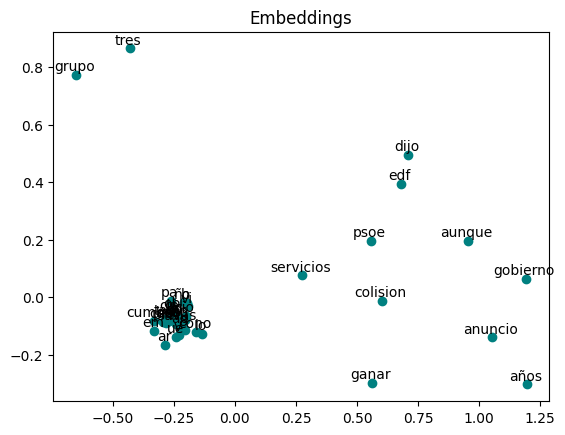

In [205]:
#Visualizando los embbedings con PCA
def plot_words(Z, ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='teal')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

plot_words(C.T[90:130], list(palabras_a_indices.keys())[90:130])
plt.title('Embeddings')
plt.show()